In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from sklearn.decomposition import PCA
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import holidays

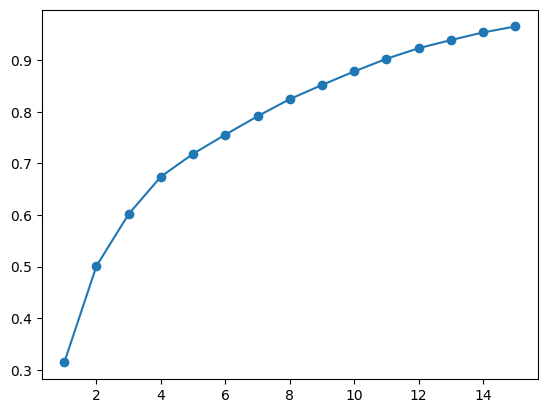

,date,holiday,moon,arrest,num_crimes,wd,wPC1,wPC2,wPC3,wPC4,wPC5,wPC6,wPC7,wPC8,wPC9,wPC10
0,2010-01-01,New Year's Day,0.0,0.216216,74,Friday,5.288286,-3.436753,-1.934371,-1.600635,-0.696136,-0.241658,1.004211,-0.902620,0.690430,0.769395
1,2010-01-02,NaN,0.0,0.431373,51,Saturday,5.641942,-3.922097,-1.749874,0.514433,-0.514419,-0.576853,0.301493,-0.932727,0.739281,0.646296
2,2010-01-03,NaN,0.0,0.340909,44,Sunday,5.507183,-3.413417,-1.835215,0.129065,-0.829286,-0.590791,0.545549,-0.652682,0.542041,0.667091
3,2010-01-04,NaN,0.0,0.403846,52,Monday,5.541083,-2.051328,-1.750198,-0.447364,-1.676371,-0.456358,1.196759,-0.052281,0.074151,0.563727
4,2010-01-05,NaN,0.0,0.557692,52,Tuesday,4.669777,-2.226177,-2.045193,-1.743263,-1.387962,-0.503352,1.536728,-0.253182,0.040211,0.699963


In [72]:
crimes = pd.read_csv('drive/MyDrive/Case_StudyBYU/Crimes.csv')
moon = pd.read_csv('drive/MyDrive/Case_StudyBYU/full_moon.csv')
weather = pd.read_csv('drive/MyDrive/Case_StudyBYU/weather.csv')

crimes['ds'] = pd.to_datetime(crimes['Date']).dt.date
crimes['ds'] = pd.to_datetime(crimes['ds'], format="%Y-%m-%d")
crimes['time'] = crimes['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y %I:%M:%S %p").time())
crimes = crimes.drop(columns=['Date', 'ID', 'Case Number', 'Location', 'Updated On'])
jan2024 = pd.DataFrame(
{
    'ds': ['2024-01-25'],
    'moon':[1]
}
)
moon['ds'] = pd.to_datetime(moon['FullMoonDates']).dt.date
moon['ds'] = pd.to_datetime(moon['ds'], format="%Y-%m-%d")
moon = moon.drop(columns=['FullMoonDates', 'Year'])
moon = pd.concat([moon, jan2024], ignore_index=True)
moon['ds'] = pd.to_datetime(moon['ds'], format="%Y-%m-%d")
moon['moon'] = 1
moon = moon[['ds', 'moon']]

weather['ds'] = pd.to_datetime(weather['datetime'])
weather['ds'] = pd.to_datetime(weather['ds'], format="%Y-%m-%d")
weather = weather.drop(columns=['datetime', 'stations', 'name', 'conditions', 'description'])
weather['sunrise'] = weather['sunrise'].apply(lambda x: datetime.fromisoformat(x).timestamp())
weather['sunset'] = weather['sunset'].apply(lambda x: datetime.fromisoformat(x).timestamp())
weather['windgust'] = weather['windgust'].fillna(0)
weather['severerisk'] = weather['severerisk'].fillna(0)
weather['preciptype'] = weather['preciptype'].fillna('none')

numeric_transformer = Pipeline(
    steps=[
        ('scale', StandardScaler()),
    ]
)
cat_transformer = Pipeline(
    steps=[
        ('onehot', OneHotEncoder())
    ]
)

pre = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selector(dtype_include=['float64', 'int64'])),
        ('cat', cat_transformer, selector(dtype_exclude=['float64', 'int64']))
    ]
)

wp = Pipeline(
    steps=[
        ('preprocessor', pre),
        ('pca', PCA(n_components=15))
    ]
)



dates = weather['ds']
w_train = weather.drop(columns=['ds'])
pcs = wp.fit_transform(w_train)
e_var = wp.named_steps['pca'].explained_variance_ratio_
e_var = np.cumsum(e_var)
plt.plot(np.arange(1, len(e_var)+1), e_var, marker='o', linestyle='-')
plt.show()
pc_keep = 10
valuable_pcs = [sub_arr[:pc_keep] for sub_arr in pcs]
valuable_pcs = pd.DataFrame(valuable_pcs, columns=[f'wPC{i}' for i in range(1,pc_keep+1)])
valuable_pcs['ds'] = dates
weather_r = valuable_pcs

# Using a different holiday calendar
holidays_calendar = pd.DataFrame()
for date, name in sorted(holidays.US(years=list(range(2001, 2025))).items()):
    holidays_calendar = pd.concat([holidays_calendar, pd.DataFrame(data=[[date, name]], columns=['ds', 'holiday'])])

holidays_calendar.drop_duplicates(subset=['ds', 'holiday'], inplace=True)
holidays_calendar = holidays_calendar[['holiday', 'ds']]
covid_calendar_initial = pd.DataFrame({'holiday': 'COVID First Rush', 'ds': pd.date_range(start='2/14/2020', end='3/15/2020')})
covid_calendar_rush = pd.DataFrame({'holiday': 'COVID First Rush', 'ds': pd.date_range(start='3/16/2020', end='4/1/2020')})
covid_calendar_spring = pd.DataFrame({'holiday': 'COVID Spring', 'ds': pd.date_range(start='4/02/2020', end='6/1/2020')})
covid_calendar_summer = pd.DataFrame({'holiday': 'COVID Summer', 'ds': pd.date_range(start='6/02/2020', end='9/1/2020')})
base_holidays_calendar = pd.concat([holidays_calendar, covid_calendar_initial, covid_calendar_spring, covid_calendar_rush, covid_calendar_summer]).reset_index(drop=True)
base_holidays_calendar['ds'] = pd.to_datetime(base_holidays_calendar['ds']).dt.date
base_holidays_calendar['ds'] = pd.to_datetime(base_holidays_calendar['ds'], format="%Y-%m-%d")
calendar = base_holidays_calendar

merged = pd.merge(
    crimes,
    calendar,
    left_on='ds',
    right_on='ds',
    how='left')

merged = pd.merge(
    merged,
    moon,
    left_on='ds',
    right_on='ds',
    how='left'
)

merged = pd.merge(
    merged,
    weather_r,
    left_on='ds',
    right_on='ds',
    how='left'
)

merged['ds'].apply(lambda x: x.weekday())
wd = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}
merged['Day of Week'] = merged['ds'].apply(lambda x: wd[x.weekday()])
min_date = np.max([calendar['ds'].min(), moon['ds'].min(), crimes['ds'].min(), weather['ds'].min()])
max_date = np.min([calendar['ds'].max(), moon['ds'].max(), crimes['ds'].max(), weather['ds'].max()])
full = merged[(merged['ds'] >= min_date)]
day_data = full.drop(columns=['Block',
                     'IUCR',
                     'Primary Type',
                     'Description',
                     'Location Description',
                     'Domestic',
                     'Beat',
                     'District',
                     'Ward',
                     'Community Area',
                     'FBI Code',
                     'X Coordinate',
                     'Y Coordinate',
                     'Year',
                     'Latitude',
                     'Longitude']).sort_values(by='ds')
day_data['num_crimes'] = 1

def percentage(x):
    return sum(x) / len(x)

day_data = day_data.groupby(by='ds').agg({
    'holiday': 'max',
    'moon': 'max',
    'Arrest': percentage,
    'num_crimes': 'sum',
    'Day of Week': 'first'
})
day_data = day_data.reset_index()
day_data['moon'] = day_data['moon'].fillna(0)
day_data = day_data.rename(columns={'ds': 'date', 'Arrest': 'arrest', 'Day of Week': 'wd'})
day_data = pd.merge(day_data, weather_r, left_on='date', right_on='ds', how='left').drop(columns=['ds'])
day_data.head()

In [74]:
day_data.to_csv('day_data.csv', index=False)

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Load the dataset
day_data = pd.read_csv("day_data.csv")

# Convert 'holiday' column to binary
day_data['holiday'] = day_data['holiday'].apply(lambda x: 0 if pd.isna(x) else 1)

# Convert 'date' column to datetime
day_data['date'] = pd.to_datetime(day_data['date'])

# Define features and target variable
Y = day_data['arrest']
X = day_data.drop(columns=['arrest', 'date'])

# One-hot encode categorical variables
X = pd.get_dummies(X, prefix='wd')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=24)

# Initialize and train a KNeighborsRegressor model
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test)

# Calculate Mean Squared Error for KNN model
mse_knn = mean_squared_error(y_test, y_pred_knn)
print("Mean Squared Error (KNN):", mse_knn)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [18]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.2 MB/s eta 0:00:00


  0%|          | 0/1022 [00:00<?, ?it/s]

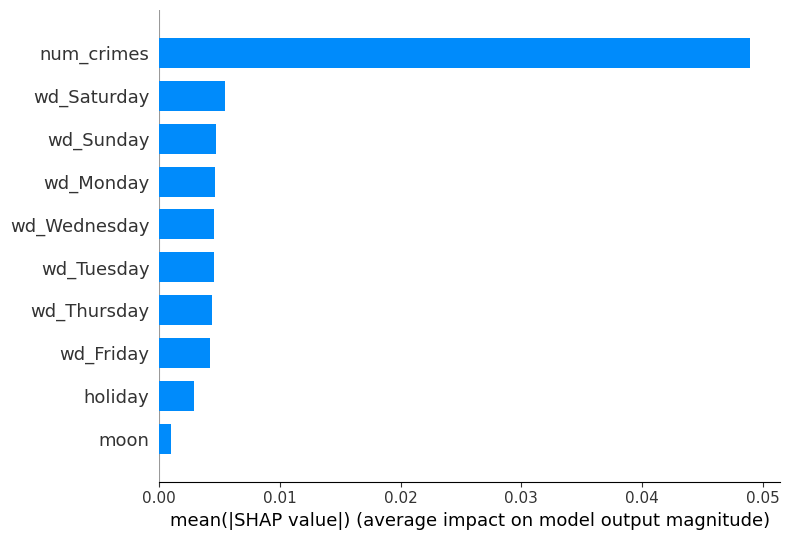

In [38]:
import shap
# Use shap.sample to summarize the background data with fewer samples
background_data = shap.sample(X_train, 100)  # Adjust the number of samples as needed

# Initialize the explainer with the KNeighborsRegressor model and the summarized background data
explainer = shap.KernelExplainer(knn_model.predict, background_data)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [71]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load the dataset
day_data = pd.read_csv("day_data.csv")

# Convert 'holiday' column to binary
day_data['holiday'] = day_data['holiday'].apply(lambda x: 0 if pd.isna(x) else 1)

# Convert 'date' column to datetime
day_data['date'] = pd.to_datetime(day_data['date'])

# Define features and target variable
X = day_data.drop(columns=['date', 'num_crimes'])
y = day_data['num_crimes']

# One-hot encode categorical variables
X = pd.get_dummies(X, prefix='wd')

# Filter data for training and testing based on date
train_data = day_data[day_data['date'] < '2023-12-01']
test_data = day_data[day_data['date'] > '2023-12-01']

# Remove datetime column from the feature set
X_train = train_data.drop(columns=['date', 'num_crimes'])
y_train = train_data['num_crimes']
X_test = test_data.drop(columns=['date', 'num_crimes'])
y_test = test_data['num_crimes']

# One-hot encode categorical variables in the training and testing sets
X_train = pd.get_dummies(X_train, prefix='wd')
X_test = pd.get_dummies(X_test, prefix='wd')

# Ensure consistency of one-hot encoded columns
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0

# Reorder columns to match training set
X_test = X_test[X_train.columns]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train a KNeighborsRegressor model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test_scaled)

# Calculate Mean Squared Error for KNN model
mse_knn = mean_squared_error(y_test, y_pred_knn)
print("Mean Squared Error (KNN):", mse_knn)


Mean Squared Error (KNN): 120.48461538461538


In [101]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Load data
day_data = pd.read_csv("day_data.csv")
day_data = day_data.rename(columns={'date':'ds'})
day_data['ds'] = pd.to_datetime(day_data['ds'], format="%Y-%m-%d")

# Preprocessing
day_data['holiday'] = day_data['holiday'].apply(lambda x: 0 if pd.isna(x) else 1)

# Extract features and target
Y = day_data['num_crimes']
X = day_data.drop(columns=['num_crimes'])

# One-hot encode categorical variables
X = pd.get_dummies(X, prefix='wd')

# Split data into train and test sets
X_train = X[X['ds'] < '2024-01-01'].drop(columns=['ds'])
y_train = Y[X['ds'] < '2024-01-01']
X_test = X[X['ds'] >= '2023-12-01'].drop(columns=['ds'])
y_test = Y[X['ds'] >= '2023-12-01']

# Model Initialization
knn_model = KNeighborsRegressor(n_neighbors=11)  # You can adjust the number of neighbors as per your requirement

# Training the model
knn_model.fit(X_train, y_train)

# Prediction
predictions = knn_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 6.141666333082189


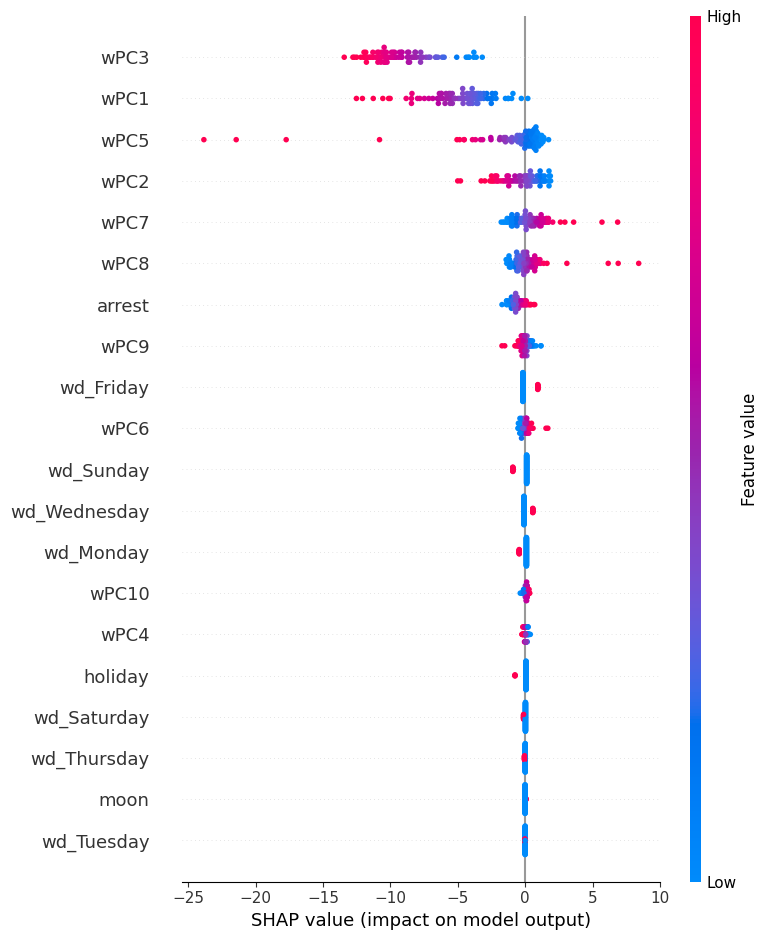

In [103]:
import shap
from sklearn.linear_model import LinearRegression

# Train a linear regression model as a surrogate to your KNN model
surrogate_model = LinearRegression()
surrogate_model.fit(X_train, knn_model.predict(X_train))

# Initialize SHAP explainer with the surrogate model
explainer = shap.Explainer(surrogate_model, X_train)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test)



